In [1]:
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots_nb.mplstyle')

We want to simulate the sky, just dealing with the unique locations on the sky. The improved point source group found there to be ~200,000 - 400,000 unique locations in the Northern Sky with our current resolution and analysis methods. This corresponds to an nside of about 256

In [3]:
nside = 256
npix = hp.nside2npix(nside)
pixels = np.arange(npix)
sky_pvals = np.zeros_like(pixels)
theta, phi = hp.pix2ang(nside, pixels)
ra = phi
dec = np.pi/2. - theta
northern_sky = dec > np.radians(-5.)

In [34]:
def get_binomial_p(pvals, max_num=10000, return_scan=False, return_num=False):
    """Calculate minimum binomial p-value from our
    list of p-values, scanning over the list of results
        - max_num: maximum number of sources to consider 
            in the scan to save time
    """
    sorted_ps = np.sort(pvals)
    obs_p = 1.
    scan = []
    for i, p in enumerate(sorted_ps[:max_num]):
        tmp = st.binom_test(i+1, len(pvals), p, alternative='greater')
        if tmp < obs_p and tmp != 0.0:
            if tmp == 0.0:
                print("WHY DOES THE BINOMIAL VALUE EQUAL ZERO")
            obs_p = tmp
        if return_scan or return_num:
            scan.append(tmp)
    if return_scan:
        scan = np.asarray(scan)
        return obs_p, scan
    elif return_num:
        return obs_p, np.argmin(np.asarray(scan))
    else:
        return obs_p

In [35]:
def run_full_binom_trials(num=1, nside=256, df=2, return_num=False):
    npix = hp.nside2npix(nside)
    pixels = np.arange(npix)
    theta, phi = hp.pix2ang(nside, pixels)
    ra = phi
    dec = np.pi/2. - theta
    northern_sky = dec > np.radians(-5.)
    sky_pvals = np.zeros_like(pixels)

    chi2 = st.chi2(df=df)
    vals = chi2.rvs(size=(npix, num))
    pvals = 1. - chi2.cdf(vals)
    pvals = np.where(northern_sky[:, np.newaxis], pvals, 1.)
        
    all_binom_p = []
    if return_num:
        all_k = []
    for pval_list in pvals.T:
        if return_num:
            binom_p, k = get_binomial_p(pval_list[northern_sky], return_num=return_num)
            all_k.append(k)
        else:
            binom_p = get_binomial_p(pval_list[northern_sky], return_num=return_num)
        all_binom_p.append(binom_p)
    if return_num:
        return np.asarray(all_binom_p), np.asarray(all_k)
    return np.asarray(all_binom_p)

In [37]:
binom_ps, num_sources = run_full_binom_trials(num=1000, return_num=True)

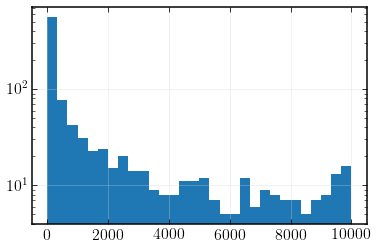

In [47]:
plt.hist(num_sources, bins=30)
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [48]:
import scipy.stats as st

In [49]:
st.percentileofscore(num_sources, 5000)

87.3

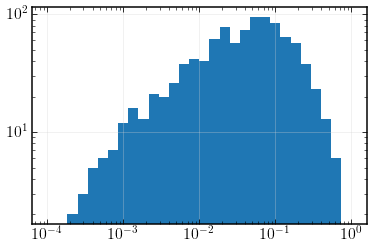

In [46]:
plt.hist(binom_ps, bins=np.logspace(-4., 0., 31))
plt.yscale('log')
plt.xscale('log')

In [17]:
aa = run_binom_trial(num=1)
aa.shape

(786432, 1)

In [5]:
df = 2
chi2 = st.chi2(df=df)
vals = chi2.rvs(size=npix)
pvals = 1. - chi2.cdf(vals)
log10p = -np.log10(pvals)

log10p = np.where(northern_sky, log10p, 0.)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


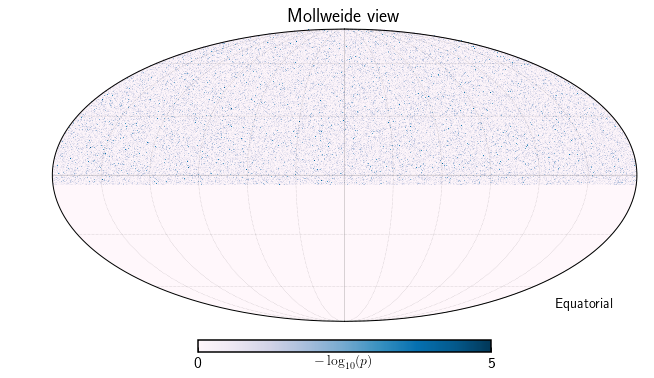

In [6]:
hp.mollview(log10p,
           coord="C",
           unit=r'$-\log_{10}(p)$',
           min=0., 
           max=5.)
hp.graticule(alpha=0.3, lw=0.5)

# First, figure out how many sources we need to consider in our binomial scan 
Out to which $k$ do we calculate $\min_kP_{binom}(k)$?

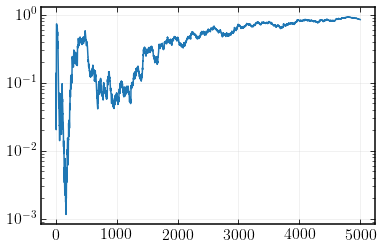

In [10]:
p, sc = get_binomial_p(pvals[northern_sky], return_scan=True)
plt.plot(sc[:5000])
plt.yscale('log')

In [62]:
np.argmin(sc)

15

(array([674., 214.,  79.,  23.,   6.,   2.,   1.,   0.,   0.,   1.]),
 array([7.70141449e-04, 2.25370991e+00, 4.50664967e+00, 6.75958943e+00,
        9.01252920e+00, 1.12654690e+01, 1.35184087e+01, 1.57713485e+01,
        1.80242883e+01, 2.02772280e+01, 2.25301678e+01]),
 <a list of 10 Patch objects>)

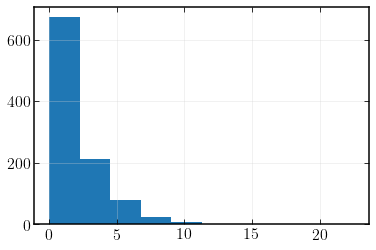

In [15]:
plt.hist(chi2.rvs(size=1000))

- Load FIRESONG
- Load effective areas
- Simulate sources
- Distribute sources amongst the sky (plot them with a colorscale/size to denote their fluxes?)
- Inject sources using csky and obtain their TS distributions for a fixed number of injected events
- Maybe do this with public data and FlareStack?

In [78]:
import francis.universe.transient_universe as uni

In [75]:
from importlib import reload

In [85]:
reload(uni)

<module 'francis.universe.transient_universe' from '/data/user/apizzuto/fast_response_skylab/alert_event_followup/FRANCIS/francis/universe/transient_universe.py'>

In [86]:
lumi = 'SC'
evol = 'MD2014SFR'
density = 1e-10
diffuse_flux_norm = 1.5e-8
diffuse_flux_ind = 2.5

uni = uni.SteadyUniverse(
    lumi, evol, density,
    diffuse_flux_norm, diffuse_flux_ind, 
    data_years=8.6)
uni

In [88]:
uni.create_universe()

In [90]:
uni.find_alerts()

In [92]:
uni.sources

{'dec': array([  8.11040381,  31.1315483 ,  11.8052132 ,  26.62953827,
         77.25110671,  15.27998513,  29.41985119, -64.10497016,
          0.47000835,  17.48907336,   3.38512349,  19.64495778,
         -0.62888822,   5.80705882,  53.7629225 ,  34.88589559,
         45.65715031,  79.05956502,  11.73968752,  17.42680086,
         29.34799244,  18.00428921,  29.28354225,  23.75100544,
         44.52505438,  -3.68811873,  -2.28875917,  27.10681717,
          7.61883465,  25.61484815,  15.76913138,  28.106477  ,
         10.29877787,  -2.43172192,  68.17639981,  49.92384203,
         -4.55027737,  43.85009419,  10.14060072,  20.88841037,
          3.53310623,  14.66255755,  11.85009945,   7.77131674,
         47.34041582,  58.69009739, -76.99867322,   2.14887211,
        -64.72625444,  -3.33808193,  54.41052567,  28.13819628,
         18.37079202,  59.91782417,  29.06705566,  -0.13959514,
         77.89067843,  66.75716465]),
 'flux': array([  6.42363216,   1.72139453,   1.2461795 ,  